# Latent Diffusion Example
This notebook contains the model architecture and basic training code for Latent Diffusion Models.

This notebook is heavily inspired by https://github.com/huggingface/diffusers/tree/main/examples/text_to_image

In [1]:
# imports
import torch
import os
from tqdm import tqdm
from accelerate import Accelerator
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from datasets import load_dataset
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel

/Users/bjorn/miniforge3/envs/diff-ex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## First we define the model parts
Latent diffusion relies on 3 main parts, the CLIP, the U-Net, and the VAE.

In [2]:
# Get pretrained text encoders and image tokenizers from the Hub
model_path = "CompVis/stable-diffusion-v1-4"
tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_path, subfolder="text_encoder")
text_encoder.requires_grad_(False)
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")
_ = vae.requires_grad_(False)

In [3]:
# Define the U-Net
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet")

In [4]:
# We also need a Noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(model_path, subfolder="scheduler")

## Define the Dataset
We use a simple pixel art dataset from https://huggingface.co/datasets/m1guelpf/nouns.

In [5]:
# Load the dataset from the hub
dataset = load_dataset("m1guelpf/nouns", "train", split="train[:50]")

Using custom data configuration m1guelpf--nouns-cc6819088b485316
Found cached dataset parquet (/Users/bjorn/.cache/huggingface/datasets/m1guelpf___parquet/m1guelpf--nouns-cc6819088b485316/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [6]:
# Prepocess the dataset
train_transforms = transforms.Compose(
    [
        transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def process(examples):
    captions = examples["text"]
    inputs = tokenizer(captions, max_length=tokenizer.model_max_length, padding="do_not_pad", truncation=True)
    examples["input_ids"] = inputs["input_ids"]
    return examples

dataset = dataset.map(process, batched=True, batch_size=20)

100%|██████████| 3/3 [00:00<00:00, 68.82ba/s]


In [7]:
def collate_fn(batch):
    batch = tokenizer.pad(batch, padding=True)
    batch["input_ids"] = torch.tensor(batch["input_ids"])
    batch["image"] = torch.stack([train_transforms(image) for image in batch["image"]])
    return batch

batch_size = 2
train_dataloader = torch.utils.data.DataLoader(
    dataset, shuffle=True, collate_fn=collate_fn, batch_size=batch_size
)
a = next(iter(train_dataloader))

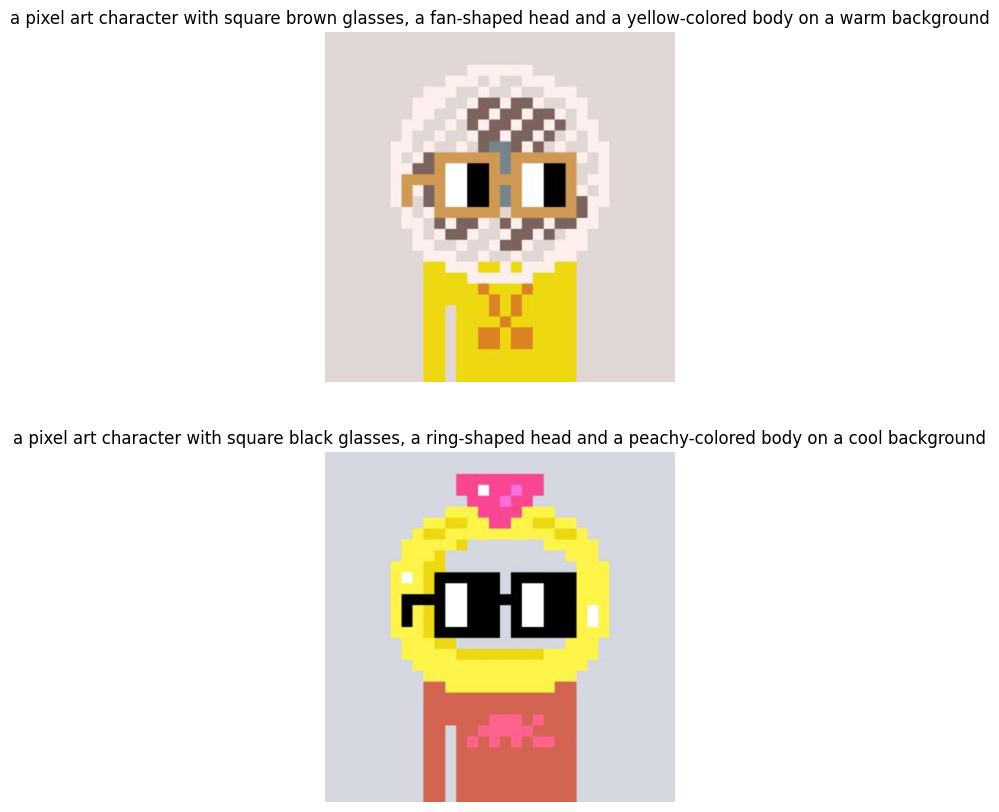

In [8]:
# Show the images of an example batch with their captions
fig, axs = plt.subplots(batch_size, 1, figsize=(5, 5*batch_size))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(a["image"][i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax.set_title(a["text"][i])
    ax.axis("off")

## Training Loop
It follows a simple training loop using HuggingFace's Accelerator library. It is derived from https://github.com/huggingface/diffusers/tree/main/examples/text_to_image following the guide at https://huggingface.co/docs/diffusers/training/text2image.

Note that this only runs on the CPU. For GPU or distributed training, as well as more arguments, please refer to the original example.


In [9]:
# Define accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision="no",
    log_with="tensorboard",
    logging_dir="./logs",
)

optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=1e-5
)
global_step = 0
accelerator.init_trackers("text2image-fine-tune")

In [10]:
unet, optimizer, train_dataloader = accelerator.prepare(
    unet, optimizer, train_dataloader
)

In [11]:
progress_bar = tqdm(range(0, len(train_dataloader)))
progress_bar.set_description("Steps")
for epoch in range(0, 1):
    unet.train()
    train_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        # Convert images to latent space
        latents = vae.encode(batch["image"]).latent_dist.sample()
        latents = latents * 0.18215

        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch_size,), dtype=torch.long)

        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        encoder_hidden_states = text_encoder(batch["input_ids"])[0]

        # Predict the noise residual and compute loss
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
        loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

        # Gather the losses across all processes for logging (if we use distributed training).
        avg_loss = accelerator.gather(loss.repeat(batch_size)).mean()
        train_loss += avg_loss.item()

        # Backpropagate
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

        logs = {"step_loss": loss.detach().item()}
        progress_bar.set_postfix(**logs)
        progress_bar.update(1)
        global_step += 1
        accelerator.log({"train_loss": train_loss}, step=global_step)
        train_loss = 0.0

    save_path = os.path.join("./outputs", f"checkpoint-{global_step}")
    accelerator.save_state(save_path)

Steps: 100%|██████████| 25/25 [10:06<00:00, 25.01s/it, step_loss=0.0317] 

In [12]:
# Save the final pipeline for later use.
pipeline = StableDiffusionPipeline.from_pretrained(
    model_path,
    text_encoder=text_encoder,
    vae=vae,
    unet=unet,
)
pipeline.save_pretrained("./outputs")


Fetching 16 files: 100%|██████████| 16/16 [00:00<00:00, 4299.65it/s]


## Inference
We can now use the pipeline to generate images from text. We use the same text from our example batch.


100%|██████████| 30/30 [00:26<00:00,  1.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


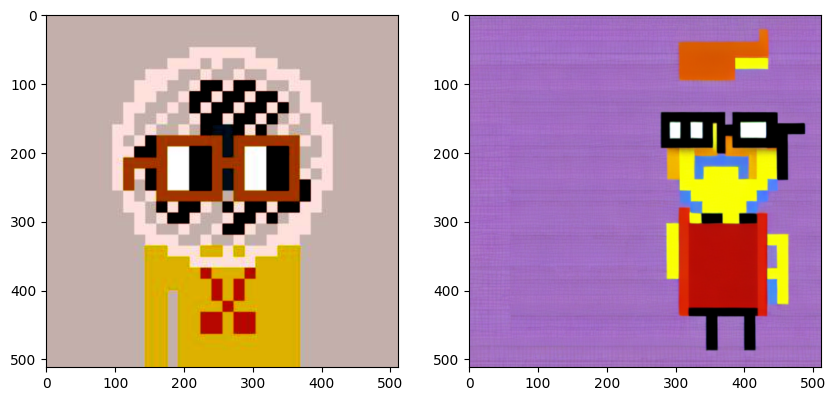

a pixel art character with square brown glasses, a fan-shaped head and a yellow-colored body on a warm background


In [13]:
prompt, target_image = a["text"][0], a["image"][0]
pipeline = pipeline.to("mps")
image = pipeline(prompt=prompt, num_inference_steps=30).images[0]
# Show both images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(target_image.permute(1, 2, 0))
ax[1].imshow(image)
plt.show()
print(prompt)